In [2]:
import os
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power
import matplotlib.pyplot as plt

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc
os.getcwd()


'/workspaces/Reproduce-of-OOK-CNNs-Demudulation'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
# os.getcwd()

### Here is some clue to understand the following function.
Non-return to zero (NRZ) OOK intensity modulation of laser light with a direct detection method using a silicon photomultiplier (SiPM) was adopted.

#### The optical signal received by the SiPM si described as follows:
$S_R0 = Res*h_0*ST_0 + n_0$  
$S_R1 = Res*h_1*ST_1 + n_1$  
0 1 indicates the bit 0 and 1,  
n_K mean the noise to bit K signal  
ST_0 indicates the  transmitted optical signal    
#### The noise can be simulated with SNR and the signal power
'sgma2_0_tn = Ptx0/(10power(SNR/10))'   
'$sgma2_1_tn = Ptx1/(10power((SNR/10)))'
#### the noise  of bit 1 is normaly distributed
  Noise_0 = np.random.normal(0, np.sqrt(sgma2_0_tn), lenth)   
  Noise_1 = np.random.normal(0, np.sqrt(sgma2_1_tn), lenth)

#### SiPM transform the optical signal to current, and converted to demodulator.
The input signals to the demodulator:  
  $S_0 = RL*S_R0$   
  $S_1 = RL*S_R1$

In [3]:

def Simulated_dataset(SNR,Z,P):
  """

  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda=420e-9 #Wavelength of Blue light
  A=0.0058  #SiPM surface area
  G=3e6 #Gain
  pap=0.002 #probability of afterpulsing
  pct=0.07 #probability of crosstalk
  dCR=300 #dark count rate6.6*10^6
  c=2.25e8 #light speed
  hp=6.626e-34  # Planck's constant h,
  e=1.6e-19  # Charge of Electron
  Nspad=4774 #  number of SPAD (microcells)
  td= 82e-9  #  tau_d deadtimex

  P_AP=1+pap #  probability of current
  P_XT = 1 + pct
  
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # what? SiPM responsitivity
  Fe=1.1  # funtion of the doping profile

  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  
  ce = 0.551 ##channel loss diffuse coefficient
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  RL = 1000 #load resistance
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor
  lenth=int(1e4)#  length of the signal and noise

#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  sgma2_0_tn = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  sgma2_1_tn = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0
  #the noise  of bit 1 is normaly distributed
  Noise_0 = np.random.normal(0, np.sqrt(sgma2_0_tn), lenth)
  Noise_1 = np.random.normal(0, np.sqrt(sgma2_1_tn), lenth)
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0
  S_R1 = Res*h_gain*Ptx1 + Noise_1 
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-8 # nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-8# nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_1_tn) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_0_tn) # standard deviation of bit 0

#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_1_tn - S_1*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn) + np.sqrt((power(S_1,2)*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn) + power((S_0*sgma2_1_tn
    - S_1*sgma2_0_tn)/(sgma2_1_tn-sgma2_0_tn),2) - (power(S_0,2)*sgma2_1_tn)/(sgma2_1_tn - sgma2_0_tn)
     - ((sgma2_0_tn*sgma2_1_tn)/(sgma2_1_tn - sgma2_0_tn))*log(sgma2_0_tn/sgma2_1_tn) )

  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


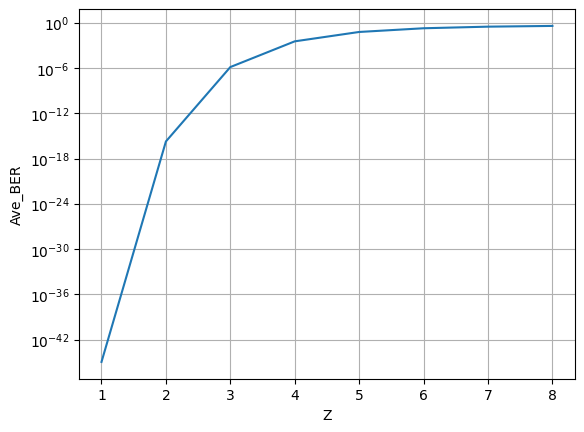

In [4]:
#####test 
# Here is a test to see if the function are working properly and if the correct BER can be obtained
SNR = 30
Avg_BER1=[]
Zb = np.linspace(1,8,8)
for Z in Zb:
    P = 0.25    #[0.25,0.40,0.5]
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P)
    #### Calculate the average BER
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER1.append(np.mean(Avg_BER_Inst))

plt.semilogy(Zb,Avg_BER1)
plt.xlabel("Z")
plt.ylabel("Ave_BER")
plt.grid(True)
plt.show()

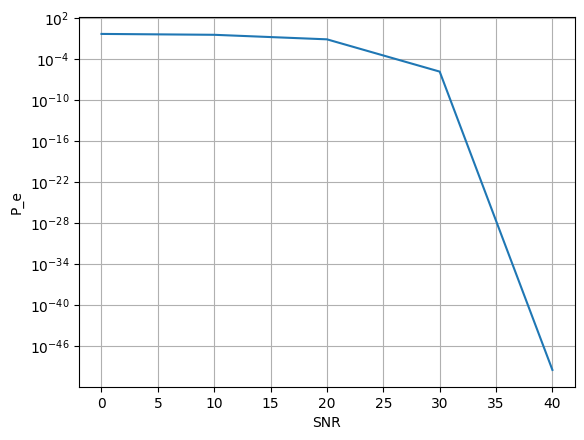

In [6]:
######The effect of SNR
Z = 3
SNR0 = np.linspace(0,40,5)
P = 0.25
Avg_BER1=[]
for SNR in SNR0:
  N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P)
  #### Calculate the average BER
  Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
  Avg_BER1.append(np.mean(Avg_BER_Inst))

plt.semilogy(SNR0,Avg_BER1)  # 对 result 取 log 后画线
plt.xlabel("SNR")
plt.ylabel("P_e")
plt.grid(True)
plt.show()


Text(0.5, 0, 'Avg_BER')

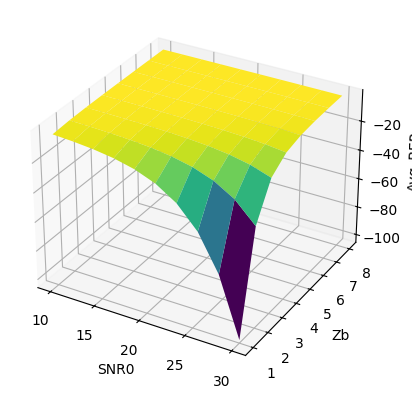

In [16]:
#### Here is the reproduce of FTD
SNR0 = np.linspace(10,30,10) # SNR range
Zb = np.linspace(1,8,8) # link range
P = [0.25,0.40,0.5] # power
X, Y = np.meshgrid(SNR0, Zb)

# Create 3D array
Avg_BER = np.zeros_like(X)
for j in range(len(Zb)):
  for  i in range(len(SNR0)):
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR0[i],Zb[j],P[0])
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER[j,i] = np.mean(Avg_BER_Inst)
Avg_BER = np.log(Avg_BER)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Avg_BER,cmap='viridis')

# Set labels
ax.set_xlabel('SNR0')
ax.set_ylabel('Zb')
ax.set_zlabel('Avg_BER')